In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from skimage.morphology import closing, square
from tools import *
from plot import *

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

## Remove unclassified data

In [7]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [106]:
print(X_indiana.shape)
print(X_indiana_idx.shape)
print(X_salinas.shape)

(10249, 200)
(10249,)
(54129, 204)


In [9]:
print(X_indiana_idx)
print(X_salinas_idx)

[    0     1     2 ... 20765 20766 20767]
[   305    306    307 ... 110691 110692 110693]


In [10]:
indiana_labels, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

In [11]:
print(indiana_labels.shape)
print(salinas_labels.shape)

(10249,)
(54129,)


## PCA

In [12]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [13]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


In [14]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [15]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split train / test

In [18]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr = shuffle(X_indiana_reduced, indiana_labels)

# shuffle index
X_indiana_idx[np.arange(indiana_labels_shuffle.size)] = X_indiana_idx[shuffle_arr]

In [91]:
print(shuffle_arr)
unmapping_shuffle = np.empty(shuffle_arr.size)
unmapping_shuffle[shuffle_arr] = np.arange(shuffle_arr.size)

[ 607  201  223 ...  492 3097 9357]


In [19]:
# nb_test = int(X_indiana_shuffle.shape[0] * 0.25)
# X_train_indiana = X_indiana_shuffle[nb_test:]
# y_train_indiana = indiana_labels_shuffle[nb_test:]
# X_test_indiana = X_indiana_shuffle[:nb_test]
# y_test_indiana = indiana_labels_shuffle[:nb_test]

In [20]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)

In [109]:
unmapping_argsort = np.empty(y_indiana_labels_argsort.size)
unmapping_argsort[y_indiana_labels_argsort] = np.arange(y_indiana_labels_argsort.size)

In [23]:
for i in range(1, n_cluster_indiana + 1):
    print(indiana_labels_shuffle[indiana_labels_shuffle == i].size)    

46
1428
830
237
483
730
28
478
20
972
2455
593
205
1265
386
93


In [24]:
labels, count = np.unique(indiana_labels_shuffle-1, return_counts=True)

In [52]:
sum_ = 0
x_train_indiana = np.empty((0, 68))
x_test_indiana = np.empty((0, 68))

train_indiana_argsort = np.array([])
test_indiana_argsort = np.array([])

y_train_indiana_labels = np.array([])
y_test_indiana_labels = np.array([])

for cluster in labels:
    idx = int(count[cluster] * 0.75)

    train_indiana_argsort = np.hstack((train_indiana_argsort, y_indiana_labels_argsort[sum_:sum_+idx]))
    x_train_indiana = np.vstack((x_train_indiana, X_indiana_shuffle[y_indiana_labels_argsort[sum_:sum_+idx]]))
    y_train_indiana_labels = np.hstack((y_train_indiana_labels, np.full((idx), cluster)))
    
    test_indiana_argsort = np.hstack((test_indiana_argsort, y_indiana_labels_argsort[sum_+idx: sum_ + count[cluster]]))   
    x_test_indiana = np.vstack((x_test_indiana, X_indiana_shuffle[y_indiana_labels_argsort[sum_+idx: sum_ + count[cluster]]]))    
    y_test_indiana_labels = np.hstack((y_test_indiana_labels, np.full((count[cluster] - idx), cluster)))
    
    print("Cluster: {}".format(cluster))
    print("Nb total samples: {}".format(count[cluster]))
    print("Nb samples train: {}".format(idx))
    print("Nb samples test: {}".format(count[cluster] - idx))
    print("---------------")
    sum_ += count[cluster]

Cluster: 0
Nb total samples: 46
Nb samples train: 34
Nb samples test: 12
---------------
Cluster: 1
Nb total samples: 1428
Nb samples train: 1071
Nb samples test: 357
---------------
Cluster: 2
Nb total samples: 830
Nb samples train: 622
Nb samples test: 208
---------------
Cluster: 3
Nb total samples: 237
Nb samples train: 177
Nb samples test: 60
---------------
Cluster: 4
Nb total samples: 483
Nb samples train: 362
Nb samples test: 121
---------------
Cluster: 5
Nb total samples: 730
Nb samples train: 547
Nb samples test: 183
---------------
Cluster: 6
Nb total samples: 28
Nb samples train: 21
Nb samples test: 7
---------------
Cluster: 7
Nb total samples: 478
Nb samples train: 358
Nb samples test: 120
---------------
Cluster: 8
Nb total samples: 20
Nb samples train: 15
Nb samples test: 5
---------------
Cluster: 9
Nb total samples: 972
Nb samples train: 729
Nb samples test: 243
---------------
Cluster: 10
Nb total samples: 2455
Nb samples train: 1841
Nb samples test: 614
-----------

In [53]:
print("Train shape: {}".format(x_train_indiana.shape))
print("Train labels shape: {}".format(y_train_indiana_labels.shape))
print("Test shape: {}".format(x_test_indiana.shape))
print("Test labels shape: {}".format(y_test_indiana_labels.shape))

Train shape: (7680, 68)
Train labels shape: (7680,)
Test shape: (2569, 68)
Test labels shape: (2569,)


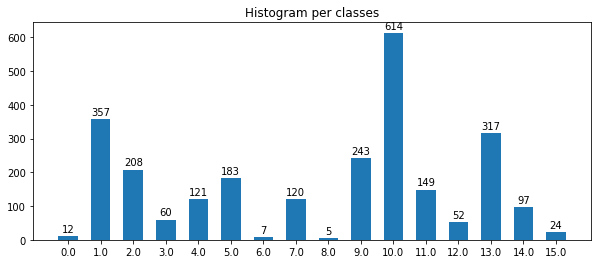

In [40]:
fig, axs = plt.subplots(figsize=(10, 4))
bar_x, bar_count = np.unique(y_test_indiana_labels, return_counts=True)

bar = axs.bar(bar_x, bar_count, 0.6)
axs.bar_label(bar, padding=2)

axs.set_xticks(np.arange(len(bar_x)))
axs.set_xticklabels(bar_x)

axs.set_title('Histogram per classes')
plt.show()

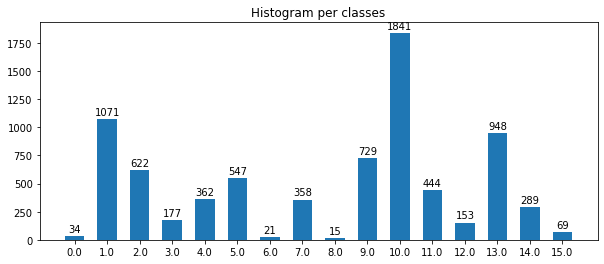

In [42]:
fig, axs = plt.subplots(figsize=(10, 4))
bar_x, bar_count = np.unique(y_train_indiana_labels, return_counts=True)

bar = axs.bar(bar_x, bar_count, 0.6)
axs.bar_label(bar, padding=2)

axs.set_xticks(np.arange(len(bar_x)))
axs.set_xticklabels(bar_x)

axs.set_title('Histogram per classes')
plt.show()

In [49]:
print("X_train shape: {}".format(x_train_indiana.shape))
print("X_test shape: {}".format(x_test_indiana.shape))
print("y_train shape: {}".format(y_train_indiana.shape))
print("y_test shape: {}".format(y_test_indiana.shape))

X_train shape: (7680, 68)
X_test shape: (2569, 68)
y_train shape: (7687,)
y_test shape: (2562,)


## Random Forest

In [66]:
modelRF = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=8)

In [67]:
modelRF.fit(x_train_indiana, y_train_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.1s finished


RandomForestClassifier(n_jobs=8, verbose=1)

In [68]:
# training score
modelRF.score(x_train_indiana, y_train_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


1.0

In [69]:
modelRF.verbose = 0
for cluster in labels:
    idxs = np.argwhere(y_train_indiana_labels == cluster).flatten()
    score = modelRF.score(x_train_indiana[idxs], y_train_indiana_labels[idxs])
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_train_indiana_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")

Cluster: 0
Nb samples: 34
Score: 1.0
-----------
Cluster: 1
Nb samples: 1071
Score: 1.0
-----------
Cluster: 2
Nb samples: 622
Score: 1.0
-----------
Cluster: 3
Nb samples: 177
Score: 1.0
-----------
Cluster: 4
Nb samples: 362
Score: 1.0
-----------
Cluster: 5
Nb samples: 547
Score: 1.0
-----------
Cluster: 6
Nb samples: 21
Score: 1.0
-----------
Cluster: 7
Nb samples: 358
Score: 1.0
-----------
Cluster: 8
Nb samples: 15
Score: 1.0
-----------
Cluster: 9
Nb samples: 729
Score: 1.0
-----------
Cluster: 10
Nb samples: 1841
Score: 1.0
-----------
Cluster: 11
Nb samples: 444
Score: 1.0
-----------
Cluster: 12
Nb samples: 153
Score: 1.0
-----------
Cluster: 13
Nb samples: 948
Score: 1.0
-----------
Cluster: 14
Nb samples: 289
Score: 1.0
-----------
Cluster: 15
Nb samples: 69
Score: 1.0
-----------


In [70]:
# testing score
modelRF.score(x_test_indiana, y_test_indiana_labels)

0.814324639937719

In [73]:
mean_score = 0
for cluster in labels:
    idxs = np.argwhere(y_test_indiana_labels == cluster).flatten()
    score = modelRF.score(x_test_indiana[idxs], y_test_indiana_labels[idxs])
    mean_score += score
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_test_indiana_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")
    
mean_score /= len(labels)
print(mean_score)

Cluster: 0
Nb samples: 12
Score: 0.16666666666666666
-----------
Cluster: 1
Nb samples: 357
Score: 0.7338935574229691
-----------
Cluster: 2
Nb samples: 208
Score: 0.5384615384615384
-----------
Cluster: 3
Nb samples: 60
Score: 0.35
-----------
Cluster: 4
Nb samples: 121
Score: 0.8925619834710744
-----------
Cluster: 5
Nb samples: 183
Score: 0.9726775956284153
-----------
Cluster: 6
Nb samples: 7
Score: 0.5714285714285714
-----------
Cluster: 7
Nb samples: 120
Score: 1.0
-----------
Cluster: 8
Nb samples: 5
Score: 0.2
-----------
Cluster: 9
Nb samples: 243
Score: 0.757201646090535
-----------
Cluster: 10
Nb samples: 614
Score: 0.9120521172638436
-----------
Cluster: 11
Nb samples: 149
Score: 0.6845637583892618
-----------
Cluster: 12
Nb samples: 52
Score: 0.9807692307692307
-----------
Cluster: 13
Nb samples: 317
Score: 0.9842271293375394
-----------
Cluster: 14
Nb samples: 97
Score: 0.5567010309278351
-----------
Cluster: 15
Nb samples: 24
Score: 0.875
-----------
0.6985128016160924


In [74]:
preds_test = modelRF.predict(x_test_indiana)
preds_train = modelRF.predict(x_train_indiana)

In [77]:
print(preds_train.shape)
print(preds_test.shape)

(7680,)
(2569,)


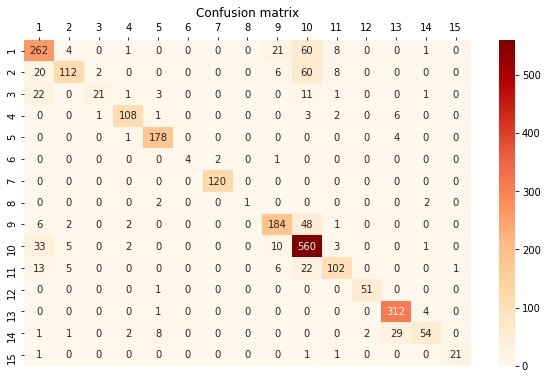

In [75]:
plot_confusion_matrix(y_test_indiana_labels, preds_test, class_names=np.arange(1, 16))

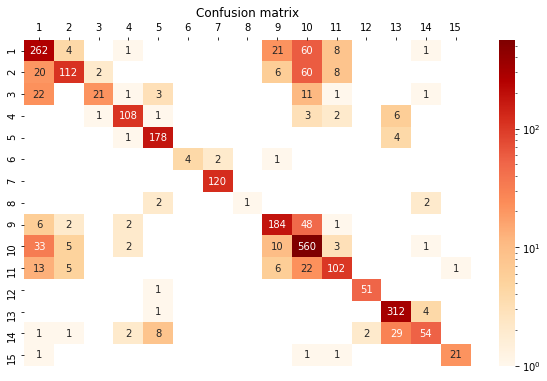

In [76]:
plot_confusion_matrix(y_test_indiana_labels, preds_test, class_names=np.arange(1, 16), log=True)

In [100]:
sum_train = 0
sum_test = 0
preds_indiana = np.empty([])

y_indiana_labels = np.array([])

for cluster in labels:
    idx = int(count[cluster] * 0.75)

    preds_indiana = np.hstack((preds_indiana, preds_train[sum_train:sum_train+idx]))
    preds_indiana = np.hstack((preds_indiana, preds_test[sum_test:sum_test+(count[cluster] - idx)]))

    y_indiana_labels = np.hstack((y_indiana_labels, y_train_indiana_labels[sum_train:sum_train+idx]))
    y_indiana_labels = np.hstack((y_indiana_labels, y_test_indiana_labels[sum_test:sum_test+(count[cluster] - idx)]))
    
    print("Cluster: {}".format(cluster))
    print("Nb total samples: {}".format(count[cluster]))
    print("Nb samples train: {}".format(idx))
    print("Nb samples test: {}".format(count[cluster] - idx))
    print("---------------")
    sum_train += idx
    sum_test += count[cluster] - idx

Cluster: 0
Nb total samples: 46
Nb samples train: 34
Nb samples test: 12
---------------
Cluster: 1
Nb total samples: 1428
Nb samples train: 1071
Nb samples test: 357
---------------
Cluster: 2
Nb total samples: 830
Nb samples train: 622
Nb samples test: 208
---------------
Cluster: 3
Nb total samples: 237
Nb samples train: 177
Nb samples test: 60
---------------
Cluster: 4
Nb total samples: 483
Nb samples train: 362
Nb samples test: 121
---------------
Cluster: 5
Nb total samples: 730
Nb samples train: 547
Nb samples test: 183
---------------
Cluster: 6
Nb total samples: 28
Nb samples train: 21
Nb samples test: 7
---------------
Cluster: 7
Nb total samples: 478
Nb samples train: 358
Nb samples test: 120
---------------
Cluster: 8
Nb total samples: 20
Nb samples train: 15
Nb samples test: 5
---------------
Cluster: 9
Nb total samples: 972
Nb samples train: 729
Nb samples test: 243
---------------
Cluster: 10
Nb total samples: 2455
Nb samples train: 1841
Nb samples test: 614
-----------

In [102]:
# unshuffle
preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
# TODO
preds_img[X_indiana_idx] = preds_indiana[unmapping_shuffle.astype(int)]

label_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
# TODO
label_img[X_indiana_idx] = y_indiana_labels[unmapping_shuffle.astype(int)]

In [103]:
print(preds_img.shape)
print(label_img.shape)

(21025,)
(21025,)


In [104]:
preds_img = preds_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))
label_img = label_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

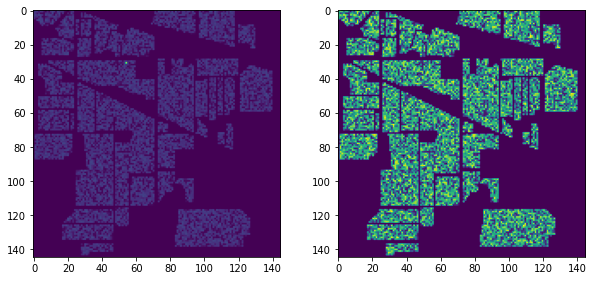

In [105]:
plot_two_figures(preds_img, label_img)

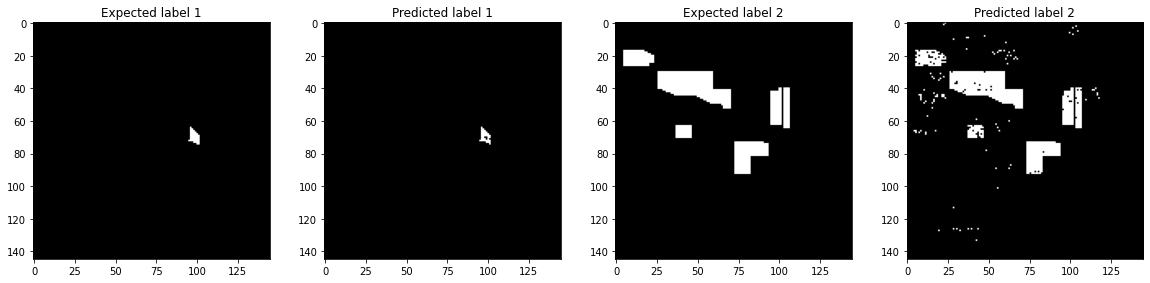

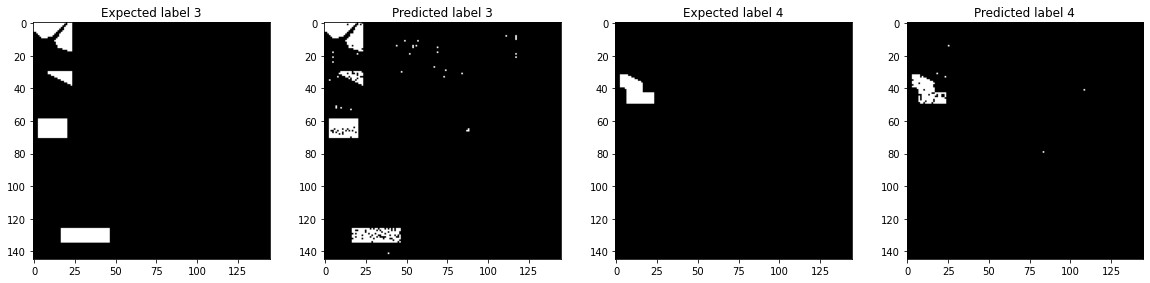

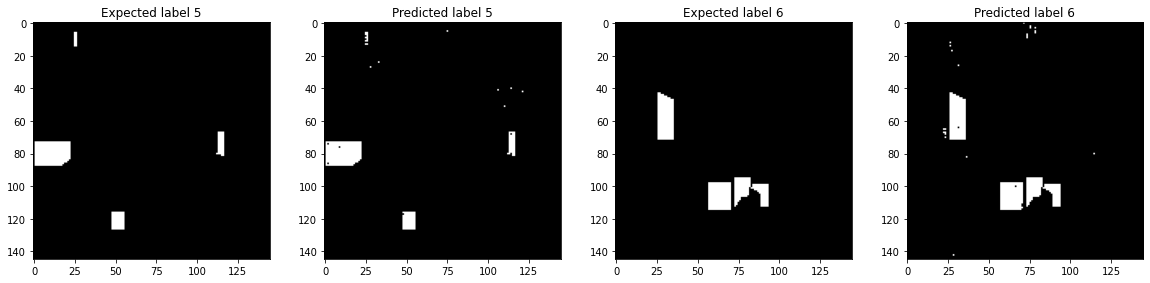

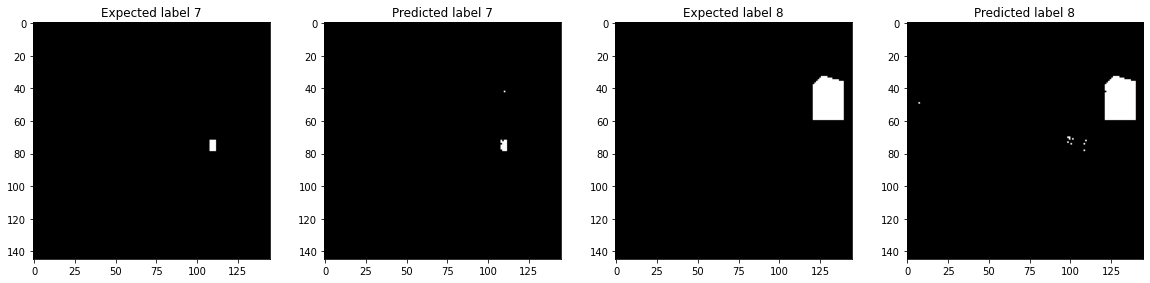

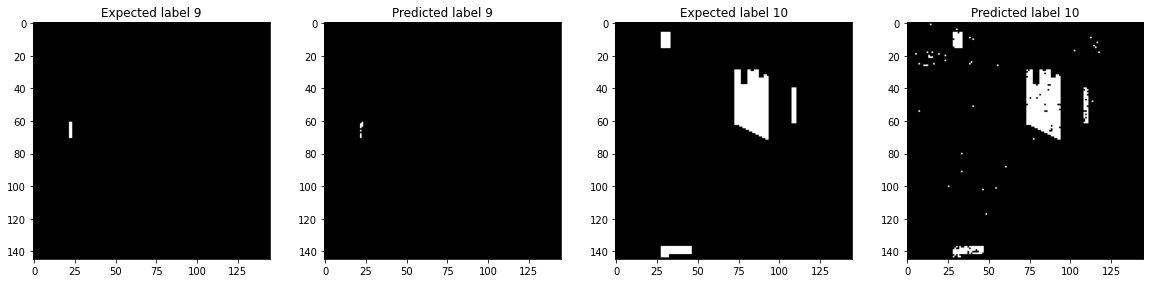

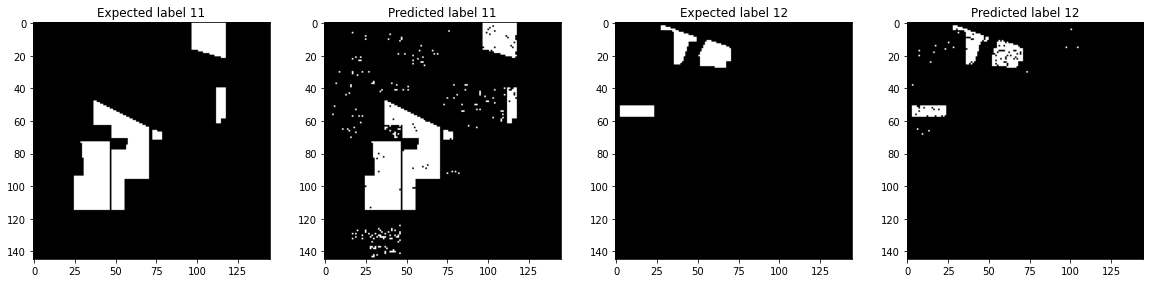

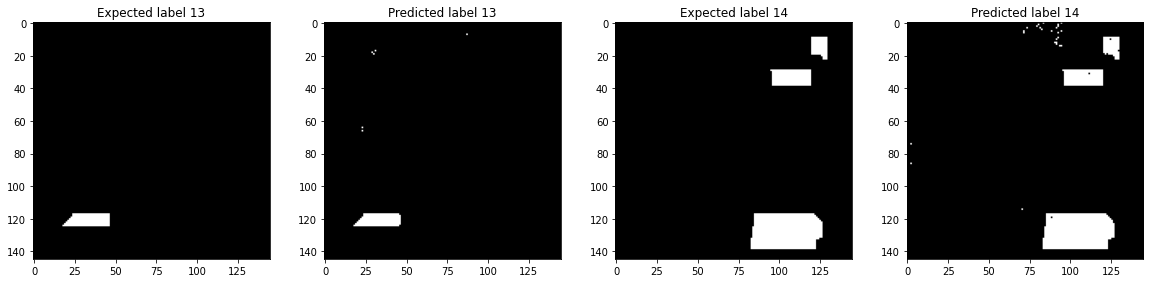

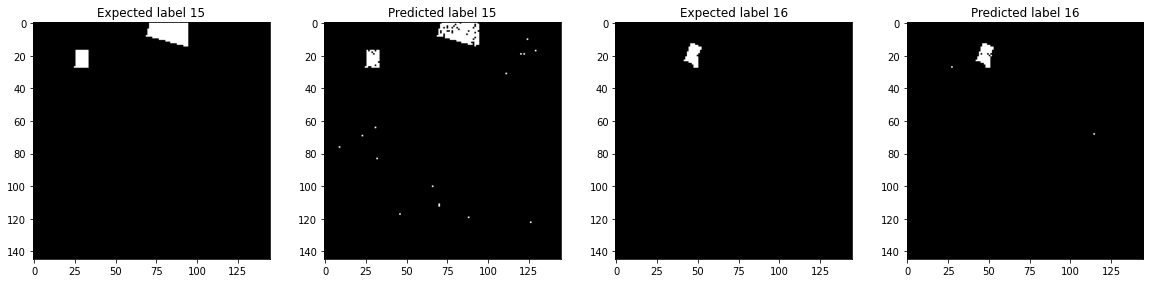

In [36]:
plot_each_labels(labels_img, pred_img, n_cluster_indiana, figsize=(20, 20), cmap='gray')